In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pyplot

In [2]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
data = scada_data[['dtTimeStamp','WindSpeedMean','WindDirectionMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean','WindDirectionMean']][0:500]
print(data.tail(100))

                     WindSpeedMean  WindDirectionMean
dtTimeStamp                                          
2019-08-03 18:40:00       3.562963          81.022222
2019-08-03 18:50:00       3.692593          84.692593
2019-08-03 19:00:00       3.985185          88.048148
2019-08-03 19:10:00       4.140741          90.981481
2019-08-03 19:20:00       4.259259          90.062963
...                            ...                ...
2019-08-04 10:30:00       2.603704         179.718519
2019-08-04 10:40:00       2.585185         191.933333
2019-08-04 10:50:00       2.637037         184.377778
2019-08-04 11:00:00       2.551852         180.733333
2019-08-04 11:10:00       2.537037         180.381481

[100 rows x 2 columns]


In [3]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

def get_predictions(data, column_name):
    X = data[[column_name]]
    size = int(len(X) * 0.1)
    train, test = X[0:size], X[size:len(X)]
    history = train
    predictions = pd.DataFrame(index=test.index, columns=[column_name])
    for i, row in test.iterrows():
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0].flatten()[0]
        predictions.loc[i][column_name] = yhat
        history.loc[i] = row[column_name]
    
    return predictions


wind_speed_predictions = get_predictions(data, 'WindSpeedMean')
wind_direction_predictions = get_predictions(data, 'WindDirectionMean')

all_predictions = pd.concat([wind_speed_predictions, wind_direction_predictions], axis='index')
print(all_predictions)


C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertati

                    WindSpeedMean WindDirectionMean
dtTimeStamp                                        
2019-08-01 08:20:00       4.89577               NaN
2019-08-01 08:30:00       4.82472               NaN
2019-08-01 08:40:00       5.14451               NaN
2019-08-01 08:50:00       5.37768               NaN
2019-08-01 09:00:00       5.34551               NaN
...                           ...               ...
2019-08-04 10:30:00           NaN           192.402
2019-08-04 10:40:00           NaN           178.076
2019-08-04 10:50:00           NaN           193.949
2019-08-04 11:00:00           NaN           183.484
2019-08-04 11:10:00           NaN           180.405

[900 rows x 2 columns]


C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\Users\hanna\Anaconda3\envs\dissertation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


In [4]:
all_predictions = pd.concat([wind_speed_predictions, wind_direction_predictions], axis=1)
print(all_predictions)

                    WindSpeedMean WindDirectionMean
dtTimeStamp                                        
2019-08-01 08:20:00       4.89577           76.4897
2019-08-01 08:30:00       4.82472           75.9632
2019-08-01 08:40:00       5.14451           74.7678
2019-08-01 08:50:00       5.37768           76.5947
2019-08-01 09:00:00       5.34551           75.4116
...                           ...               ...
2019-08-04 10:30:00       2.64034           192.402
2019-08-04 10:40:00       2.60302           178.076
2019-08-04 10:50:00       2.58189           193.949
2019-08-04 11:00:00       2.64609           183.484
2019-08-04 11:10:00       2.53689           180.405

[450 rows x 2 columns]


In [5]:
import os
import sys

new_path = r'C:\Users\hanna\Documents\GitHub\dissertation'
sys.path.append(new_path)

from api.noise_campaign.histogram import Histogram

In [6]:
h = Histogram(3, 12, 1, 12)
wind_speed_bins = h.get_wind_speed_bins()
wind_direction_bins = h.get_wind_direction_bins()

In [28]:
wind_speed_bins

{3: [2.5, 3.5],
 4: [3.5, 4.5],
 5: [4.5, 5.5],
 6: [5.5, 6.5],
 7: [6.5, 7.5],
 8: [7.5, 8.5],
 9: [8.5, 9.5],
 10: [9.5, 10.5],
 11: [10.5, 11.5],
 12: [11.5, 12.5],
 13: [12.5, 13.5],
 14: [13.5, 14.5]}

In [7]:
wind_direction_bins

{0.0: [-15.0, 15.0],
 30.0: [15.0, 45.0],
 60.0: [45.0, 75.0],
 90.0: [75.0, 105.0],
 120.0: [105.0, 135.0],
 150.0: [135.0, 165.0],
 180.0: [165.0, 195.0],
 210.0: [195.0, 225.0],
 240.0: [225.0, 255.0],
 270.0: [255.0, 285.0],
 300.0: [285.0, 315.0],
 330.0: [315.0, 345.0]}

In [8]:
import itertools
bins = [list(itertools.chain(*wind_speed_bins.values())), list(itertools.chain(*wind_direction_bins.values()))]

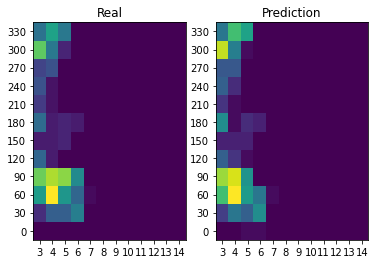

In [9]:
x_raw = data['WindSpeedMean']
y_raw = data['WindDirectionMean']
x_pred = all_predictions['WindSpeedMean']
y_pred = all_predictions['WindDirectionMean']

fig, axes = pyplot.subplots(1, 2)
axes[0].hist2d(x_raw, y_raw, bins=bins)
axes[0].title.set_text('Real')
axes[1].hist2d(x_pred, y_pred, bins=bins)
axes[1].title.set_text('Prediction')

axes[0].set_xticks(list(wind_speed_bins.keys()))
axes[0].set_yticks(list(wind_direction_bins.keys()))

axes[1].set_xticks(list(wind_speed_bins.keys()))
axes[1].set_yticks(list(wind_direction_bins.keys()))
       
pyplot.show()

In [10]:
data["SpeedBin"] = data['WindSpeedMean'].apply(h.get_wind_speed_bin)
data["DirectionBin"] = data['WindDirectionMean'].apply(h.get_wind_direction_bin)

all_predictions["PredictedSpeedBin"] = all_predictions['WindSpeedMean'].apply(h.get_wind_speed_bin)
all_predictions["PredictedDirectionBin"] = all_predictions['WindDirectionMean'].apply(h.get_wind_direction_bin)

In [11]:
comp = pd.DataFrame()

comp['WindSpeedMean'] = data['WindSpeedMean']
comp['WindDirectionMean'] = data['WindDirectionMean']

comp['PredictedWindSpeedMean'] = all_predictions['WindSpeedMean']
comp['PredictedWindDirectionMean'] = all_predictions['WindDirectionMean']

comp['SpeedBin'] = data['SpeedBin']
comp['DirectionBin'] = data['DirectionBin']
comp['PredictedSpeedBin'] = all_predictions["PredictedSpeedBin"] 
comp['PredictedDirectionBin'] = all_predictions["PredictedDirectionBin"] 

comp.dropna(inplace=True)
comp['SpeedBinEqual'] = comp['SpeedBin'] == comp["PredictedSpeedBin"]
comp['DirectionBinEqual'] = comp['DirectionBin'] == comp["PredictedDirectionBin"]

comp.shape

(396, 10)

In [24]:
wrong = comp.query('DirectionBinEqual == False or SpeedBinEqual == False')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

from sklearn.metrics import mean_squared_error
import math 

print("\nMSE for speed")
print(mean_squared_error(comp['WindSpeedMean'], comp['PredictedWindSpeedMean']))

print("\nMSE for direction")
print(math.degrees(mean_squared_error(comp['WindDirectionMean'].apply(math.radians), comp['PredictedWindDirectionMean'].apply(math.radians))))

Percentage of bins wrong:
43.43434343434344

MSE for speed
0.07255393701155165

MSE for direction
15.18131893700203


In [35]:
import numpy as np
comp['SpeedBinDifference'] = comp['SpeedBin'] - comp["PredictedSpeedBin"]
comp['DirectionBinDifference'] = (comp['DirectionBin'] - comp["PredictedDirectionBin"]) / 30

In [36]:
comp.query('DirectionBinEqual == False or SpeedBinEqual == False')

,WindSpeedMean,WindDirectionMean,PredictedWindSpeedMean,PredictedWindDirectionMean,SpeedBin,DirectionBin,PredictedSpeedBin,PredictedDirectionBin,SpeedBinEqual,DirectionBinEqual,SpeedBinDifference,DirectionBinDifference
dtTimeStamp,,,,,,,,,,,,
2019-08-01 08:30:00,5.014815,74.933333,4.82472,75.9632,5.0,60.0,5.0,90.0,True,False,0.0,-1.0
2019-08-01 08:40:00,5.222222,75.970370,5.14451,74.7678,5.0,90.0,5.0,60.0,True,False,0.0,1.0
2019-08-01 09:20:00,5.114815,74.211111,5.0258,75.5939,5.0,60.0,5.0,90.0,True,False,0.0,-1.0
2019-08-01 10:20:00,4.181481,68.574074,4.50591,68.6227,4.0,60.0,5.0,60.0,False,True,-1.0,0.0
2019-08-01 10:30:00,4.196296,76.214815,3.99633,68.9426,4.0,90.0,4.0,60.0,True,False,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-04 00:10:00,4.892593,76.392593,4.76145,74.5967,5.0,90.0,5.0,60.0,True,False,0.0,1.0
2019-08-04 01:30:00,4.459259,95.700000,4.66847,92.7031,4.0,90.0,5.0,90.0,False,True,-1.0,0.0
2019-08-04 03:20:00,3.451852,96.966667,3.5874,97.0878,3.0,90.0,4.0,90.0,False,True,-1.0,0.0


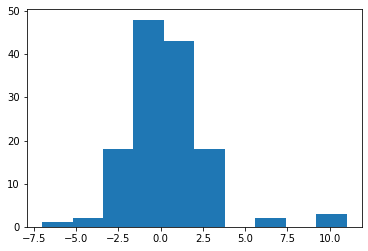

In [37]:
fig, axes = pyplot.subplots()
axes.hist(comp[comp["DirectionBinDifference"] != 0]["DirectionBinDifference"])

pyplot.show()

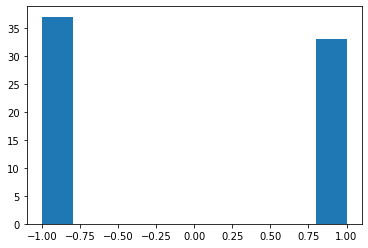

In [38]:
fig, axes = pyplot.subplots()
axes.hist(comp[comp["SpeedBinDifference"] != 0]["SpeedBinDifference"])
#axes.set_xticks(list(range(1,11)))
pyplot.show()

In [55]:
wrong = comp.query('SpeedBinDifference in [-1,1]')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)


Percentage of bins wrong:
17.67676767676768


In [56]:
wrong = comp.query('DirectionBinDifference in [-1,1]')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
22.97979797979798


In [57]:
wrong = comp.query('DirectionBinDifference in [-1,1] or SpeedBinDifference in [-1,1]')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
34.84848484848485


In [46]:
wrong = comp.query('SpeedBinDifference in [-1,1]')
len(wrong)

70

In [47]:
wrong = comp.query('DirectionBinDifference in [-1,1]')
len(wrong)

91

In [48]:
comp.shape[0]

396

In [51]:
wrong = comp.query('DirectionBinDifference == -1')
len(wrong) / comp.shape[0]

0.12121212121212122

In [52]:
wrong = comp.query('DirectionBinDifference == 1')
len(wrong) / comp.shape[0]

0.10858585858585859

In [53]:
wrong = comp.query('SpeedBinDifference == -1')
len(wrong) / comp.shape[0]

0.09343434343434344

In [54]:
wrong = comp.query('SpeedBinDifference == 1')
len(wrong) / comp.shape[0]

0.08333333333333333